# A Deep Learning Approach to Quantifying COVID 19 Reporting Inaccuracies in the US
## CS230 Final Project 2021
### Sameer Sundrani and Amy Zhang
### TA Mentor: Ruta & Ayush

# Imported Libraries & gDrive Mounting

In [ ]:
import numpy as np
import pandas as pd
import time
#TO DO: IMPORT ALL FILES HERE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import explained_variance_score #for linear regression evaluation
from sklearn import linear_model
from sklearn import preprocessing
#END TO DO
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '/content/drive/MyDrive/CS230_FINAL_PROJECT'


Mounted at /content/drive


# Data Processing & Dataset Preparation

In [ ]:
travel_data_raw = pd.read_csv(FOLDERNAME + "/Trips_by_Distance.csv")
covid_counts_raw = pd.read_csv(FOLDERNAME + "/us-counties.csv"

In [ ]:
#travel_data_raw.head()
travel_counties = travel_data_raw.loc[travel_data_raw['Level'] == "County"]
travel_counties_final = travel_counties[['Date', 'State Postal Code', 'County Name', 'Number of Trips', 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']]
travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])
travel_counties_final = travel_counties_final.rename(columns={"Date": "date", "State Postal Code": "state", "County Name": "county"})
travel_counties_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,state,county,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
21061,2021/06/06,WY,Weston,22471.0,4160.0,2601.0,948.0,1558.0,5723.0,2202.0,3930.0,1160.0,166.0,23.0
22762,2021/06/06,AR,Bradley,25022.0,3411.0,4145.0,5901.0,4321.0,3343.0,1793.0,1383.0,690.0,35.0,0.0
22763,2021/06/06,AR,Calhoun,17543.0,2166.0,2168.0,3195.0,3600.0,4277.0,1141.0,530.0,425.0,41.0,0.0
22764,2021/06/06,AR,Carroll,77047.0,14712.0,16029.0,11434.0,13170.0,14712.0,4272.0,1227.0,1323.0,132.0,36.0
22765,2021/06/06,AR,Chicot,31550.0,9483.0,6752.0,4547.0,3929.0,3857.0,1380.0,580.0,957.0,61.0,4.0


In [ ]:
covid_counts_final = covid_counts_raw[['date', 'county', 'state', 'cases']]
covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}
covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])
covid_counts_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,county,state,cases
0,2020/01/21,Snohomish,WA,1
1,2020/01/22,Snohomish,WA,1
2,2020/01/23,Snohomish,WA,1
3,2020/01/24,Cook,IL,1
4,2020/01/24,Snohomish,WA,1


In [ ]:
final_data = pd.merge(covid_counts_final, travel_counties_final)
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [ ]:
final_data.to_csv(FOLDERNAME+'/final_data.csv')

In [ ]:
print("Number of Total Inputs: ", len(final_data))
# print("Confirmed (number should be the same): ",np.sum(final_data.groupby('county').size().to_list()))
print("Number of Total Counties: " ,len(final_data.groupby('county').size().to_list()))

Number of Total Inputs:  1609217
Number of Total Counties:  1620


# Initial Data Visualization - Number Recorded Days per County (Initial Distribution)

Text(0, 0.5, 'Number of Recorded Days')

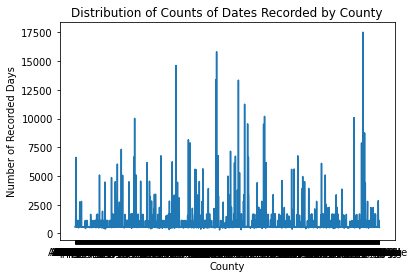

In [ ]:
cases_by_county_df = final_data.groupby('county').size()
plt.plot(cases_by_county_df)
plt.title('Distribution of Counts of Dates Recorded by County')
plt.xlabel('County')
plt.ylabel('Number of Recorded Days')

# Initial Modeling (Begin **Here** if Data is Preprocessed)

In [ ]:
final_data = pd.read_csv(FOLDERNAME+'/final_data.csv').iloc[0:, 1:]
final_data = final_data.dropna()
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [ ]:
#Quick Check for NA/NaN in data
final_data.isnull().any()

date                       False
county                     False
state                      False
cases                      False
Number of Trips            False
Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

In [ ]:
#Check Dates: 
dates_ordered = final_data.groupby('date')
dates_ordered.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606319,2021/10/09,Autauga,AL,9843,157429.0,35283.0,35381.0,16280.0,19496.0,36916.0,7960.0,3687.0,2096.0,285.0,45.0
1606320,2021/10/09,Baldwin,AL,36870,602903.0,125819.0,147443.0,75865.0,97680.0,105601.0,35869.0,8170.0,4230.0,1730.0,496.0
1606321,2021/10/09,Barbour,AL,3545,82550.0,18235.0,16826.0,10033.0,18291.0,10029.0,6079.0,2213.0,687.0,147.0,10.0
1606322,2021/10/09,Bibb,AL,4192,68339.0,8012.0,16078.0,7679.0,18108.0,9321.0,6373.0,2150.0,510.0,96.0,12.0


In [ ]:
print("To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values)) ", len(final_data))

To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of previous null values))  1602900


In [ ]:
# normalize travel data portion of final_data to have zero mean and unit variance to optimize learning
scaler = preprocessing.StandardScaler().fit(final_data.iloc[:, 4:])
final_data.iloc[:, 4:] =  scaler.transform(final_data.iloc[:, 4:])
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2.987427,2.691879,3.069250,2.572461,2.770508,3.852225,3.779457,1.243063,0.303066,0.409213,2.704416
1,2020/01/22,Snohomish,WA,1,3.058977,2.777671,3.095057,2.606155,2.884339,3.944103,3.937135,1.311168,0.179679,0.330569,2.198916
2,2020/01/23,Snohomish,WA,1,2.996701,2.769628,3.057758,2.548271,2.679002,3.819372,3.980777,1.392484,0.420929,0.398164,2.515539
3,2020/01/24,Cook,IL,1,23.935238,24.534035,24.209167,24.237793,24.187216,23.008318,19.976349,10.637648,13.975480,15.490744,12.750149
4,2020/01/24,Snohomish,WA,1,3.241778,3.069397,3.320916,2.824478,3.009235,3.930521,3.808948,1.502355,0.634220,0.533355,2.988123


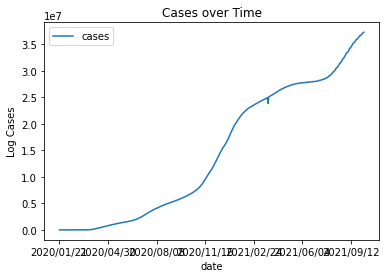

In [ ]:
# See cases over the entire dataset, grouped by day
dates_ordered[['date', 'cases']].sum('cases').plot(title='Cases over Time', ylabel='Log Cases')

**Define Train, Val, Test Sets and Normalize All Feature Vectors**

In [ ]:
# shuff = final_data.sample(frac=1)
# X = shuff.iloc[:,4:] #if wanted to shuffle data before splits
time_split_all_data = final_data[['cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']].copy() #if we want to just use split by time
#min_max_scaler = preprocessing.MinMaxScaler()
#time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])

xy_train = time_split_all_data.iloc[160291:, :] #train on later part of data
X_train = xy_train.iloc[:, 1:]
y_train = xy_train['cases']

xy_val_test = time_split_all_data.iloc[0:160290, :] #val and test on beginning of data
X_val_test = xy_val_test.iloc[:, 1:]
y_val_test = xy_val_test['cases']

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [ ]:
print("Train Set Dimensions : ", X_train.shape)
print("Train Labels Dimensions : ", y_train.shape)
print("Val Set Dimensions : ", X_val.shape)
print("Val Labels Dimensions : ", y_val.shape)
print("Test Set Dimensions : ", X_test.shape)
print("Test Labels Dimensions : ", y_test.shape)

Train Set Dimensions :  (1442609, 10)
Train Labels Dimensions :  (1442609,)
Val Set Dimensions :  (80145, 10)
Val Labels Dimensions :  (80145,)
Test Set Dimensions :  (80145, 10)
Test Labels Dimensions :  (80145,)


In [ ]:
X_train.head()

,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
160299,-0.309639,-0.360427,-0.366456,-0.369464,-0.363402,-0.403013,-0.383262,-0.302320,-0.278438,-0.211025
160300,-0.006330,-0.009394,-0.067866,-0.177383,-0.178855,-0.124712,0.541732,0.510498,0.455360,-0.031553
160301,-0.280227,-0.304926,-0.294727,-0.313200,-0.326699,-0.326691,-0.299644,0.011590,-0.120499,-0.178893
160302,-0.282338,-0.266631,-0.332399,-0.331608,-0.318766,-0.349408,-0.328881,-0.291772,-0.120499,-0.170272
160303,-0.038579,-0.081552,-0.143209,-0.170409,-0.156369,0.029961,0.271786,0.904267,0.084236,-0.069956


In [ ]:
#Double check that we have no null/NA values
X_train.isnull().any()

Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

Text(0, 0.5, 'Case Count')

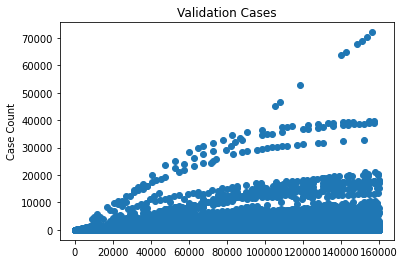

In [ ]:
plt.scatter(X_val.index, y_val, marker='o')
plt.title('Validation Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

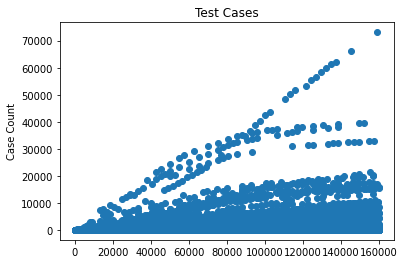

In [ ]:
plt.scatter(X_test.index, y_test, marker='o')
plt.title('Test Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

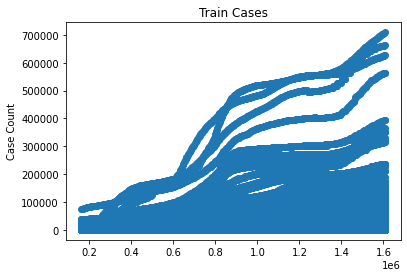

In [ ]:
plt.scatter(X_train.index, y_train, marker='o')
plt.title('Train Cases')
plt.ylabel('Case Count')

## Lasso Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) (L1 Regression)

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  26.065693855285645  ms


In [ ]:
reg_lasso_params = reg_lasso.get_params()
print(reg_lasso_params)

{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 100000, 'n_alphas': 100, 'n_jobs': None, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': 1, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}


In [ ]:
print(reg_lasso.coef_)
print(reg_lasso.intercept_)

[ 30731.34551709 -29932.36679242   9016.94197029   8592.66086112
    -56.31770971   1564.66479952   -262.87117501    243.9029377
    337.65074779   -741.06857771]
6382.091728219687


In [ ]:
y_pred = reg_lasso.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -165.08358390029352


Text(0, 0.5, 'Predicted')

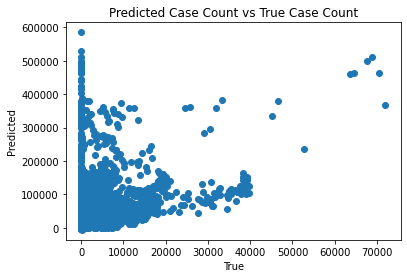

In [ ]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

##Ridge Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) (L2 Regression)

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  1.1318812370300293  ms


In [ ]:
reg_ridge_params = reg_ridge.get_params()
print(reg_ridge_params)

{'alphas': array([ 0.1,  1. , 10. ]), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'normalize': False, 'scoring': None, 'store_cv_values': False}


In [ ]:
print(reg_ridge.coef_)
print(reg_ridge.intercept_)

[ 32418.1196839  -36376.87840974  13519.37703388  10230.49157886
  -2759.63209134   3216.52025195   -701.71965055    496.17427559
    238.55117549   -794.33190875]
6366.502092570237


In [ ]:
y_pred = reg_ridge.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -161.2136648356446


Text(0, 0.5, 'Predicted')

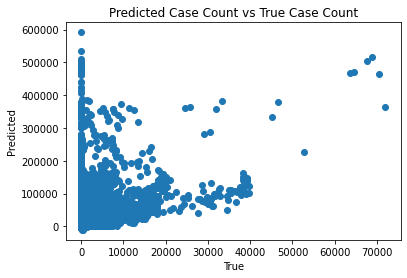

In [ ]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

## Split by State (proxy for testing quality) (https://www.nytimes.com/interactive/2020/us/coronavirus-testing.html)

In [ ]:
#final_data.head()
state_split_all_data = final_data[['state', 'cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']].copy()
#First, we normalize using sklearn's MinMaxScaler()
#x2 = X2.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])
state_split_all_data_normalized = state_split_all_data.sample(frac=1) #shuffle everything

X2 = state_split_all_data_normalized[['state', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']]
y2 = state_split_all_data_normalized['cases']


In [ ]:
X_train2 = X2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA'])]
X_train2 = X_train2.iloc[:, 1:]
y_train2 = y2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA'])]

X_val_test2 = X2[X2['state'].isin(['SD', 'IA', 'WY'])]
X_val_test2 = X_val_test2.iloc[:, 1:]
y_val_test2 = y2[X2['state'].isin(['SD', 'IA', 'WY'])]

X_val_states, X_test_states, y_val_states, y_test_states = train_test_split(X_val_test2, y_val_test2, test_size=0.50, random_state=1)

In [ ]:
print("Train Set Dimensions : ", X_train2.shape)
print("Train Labels Dimensions : ", y_train2.shape)
print("Val Set Dimensions : ", X_val_states.shape)
print("Val Labels Dimensions : ", y_val_states.shape)
print("Test Set Dimensions : ", X_test_states.shape)
print("Test Labels Dimensions : ", y_test_states.shape)

Train Set Dimensions :  (182029, 10)
Train Labels Dimensions :  (182029,)
Val Set Dimensions :  (48066, 10)
Val Labels Dimensions :  (48066,)
Test Set Dimensions :  (48067, 10)
Test Labels Dimensions :  (48067,)


### Lasso Regression

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train2, y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')


STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  4.436180353164673  ms


In [ ]:
y_pred_states = reg_lasso.predict(X_val_states)
exp_var_score = explained_variance_score(y_val_states, y_pred_states)
print("Score = ", exp_var_score) #Note that 1.0 is the best

print(reg_lasso.coef_)
print(reg_lasso.intercept_)


Score =  0.6709799052685965
[ 21544.98466081 -23554.69623764  21455.08649813  -1630.84380488
  -6077.70833792   3841.61542407   1368.47400173    300.41329561
   1194.67621448  -2882.0190461 ]
4172.102645346794


Text(0, 0.5, 'Predicted')

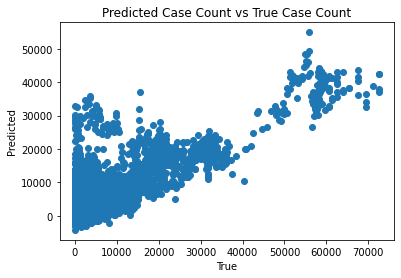

In [ ]:
plt.scatter(y_val_states, y_pred_states) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

### Ridge Regression

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train2, y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  0.1819171905517578  ms


In [ ]:
y_pred_states = reg_ridge.predict(X_val_states)
exp_var_score = explained_variance_score(y_val_states, y_pred_states)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  0.6571461621501336


Text(0, 0.5, 'Predicted')

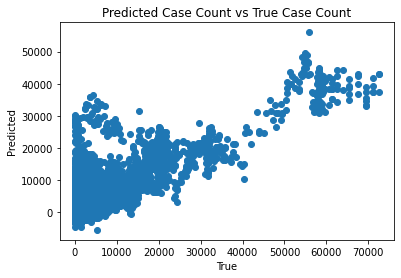

In [ ]:
plt.scatter(y_val_states, y_pred_states) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')